# Basket Ball Computer Vision

The idea is to perform two sets of analysis. Essentially I want to how the mnist network 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import argparse
import sys
import tempfile
import cv2
import csv
import glob
import pandas as pd
import numpy as np
from tensorflow.contrib.data import Dataset, Iterator

%run lib/util.py # contains utilities to retrieve the data from the basketball image folder

import tensorflow as tf

The function below is essentially a dead copy of the tensor flow deep example, showing how to build a proper network. I've modified to allow it to deal with variable values from height, width and classification labels

In [2]:
def mnist_network(x, height, width, num_labels):
  """ builds the mnist neural net for analysing arbitrary dimension images
  Args:
    x: an input tensor with the dimensions 
    height: height of the image
    widht: width of the image
    
  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, num_labels), with values
    equal to the logits of classifying the image into one of num_labels classes. 
    keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, height, width, 3])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 3, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  with tf.name_scope('fc1'):
    W_fc1 = weight_variable([10 * 10 * 64, 128])
    b_fc1 = bias_variable([128])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 10*10*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the features to num_labels classes
  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([128, num_labels])
    b_fc2 = bias_variable([num_labels])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob

Helper function below from the tensor flow deep tutorial 

In [3]:
def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [4]:
def batch_data(training_images, training_ground_truth, batch_size, epoch):
    """returns a tf data with it's iterator and initialiser for given batch size and epoch """
    # create TensorFlow Dataset objects
    tr_data = Dataset.from_tensor_slices((training_images.values, training_ground_truth.values))
    tr_data = tr_data.shuffle(buffer_size=10000)
    tr_data = tr_data.batch(batch_size)
    
    # if epoch none then don't repeat at all
    if epoch :
        tr_data = tr_data.repeat(epoch)

    # create TensorFlow Iterator object
    iterator = Iterator.from_structure(tr_data.output_types,
                                     tr_data.output_shapes)

    next_element = iterator.get_next()

    training_init_op = iterator.make_initializer(tr_data)
    return (tr_data, next_element, training_init_op)

## Model Creation

Now the fun begins, we specify the input placeholder create the loss function and convert the data into a data frame for manipulation

In [5]:
# Create the model
width = 40
height = 40
x = tf.placeholder(tf.float32, [None, height * width * 3])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 2])

# Build the graph for the deep net
y_conv, keep_prob = mnist_network(x, height, width, num_labels=2)
y_conv_orig, keep_prob_orig = mnist_network(x, height, width, num_labels=2)

prediction_ = tf.placeholder(tf.float32, [None, 2])

# get rescaled training data and convert to data frame
(images, ground_truth) = get_rescaled_image(40, 40)
images_df = pd.DataFrame(data=images)
ground_truth_df = pd.DataFrame(data=ground_truth)

## Equal amount negative and positive examples

So what we need to do to test the  idea of a training set with equalish amount of samples of containing basketballs and not containing basketballs

In [6]:
# segregate into training and test data
num_images = images_df.shape[0]
train_length = int(0.8 * num_images)
training_images = images_df[: train_length]
training_ground_truth = ground_truth_df[: train_length]


training_images_ad = training_images[training_ground_truth[0] == 1]
training_ground_truth_ad = training_ground_truth[training_ground_truth[0] == 1]

training_images_eq = training_images
training_ground_truth_eq = training_ground_truth

for i in range(4):
    training_images_eq = training_images.append(training_images_ad)  
    training_ground_truth_eq = training_ground_truth.append(training_ground_truth_ad)

test_images = images_df[train_length + 1:]
test_ground_truth = ground_truth_df[train_length + 1:]

test_images = test_images[test_ground_truth[0] == 1]
test_ground_truth = test_ground_truth[test_ground_truth[0] == 1]

print("Number of bballs images in traing set: %d", (training_ground_truth[training_ground_truth[0]==1].shape)) 
print("Number of neg bballs images in traing set: %d", (training_ground_truth[training_ground_truth[0]==0].shape)) 


Number of bballs images in traing set: %d (64, 2)
Number of neg bballs images in traing set: %d (300, 2)


### Shuffle Data

We need to shuffle data so batch training gets good mix of training instances per batch

In [7]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                            logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

graph_location = tempfile.mkdtemp()
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: C:\Users\crisyp\AppData\Local\Temp\tmpowq3ta_x


Get batch data which has been enhanced by adding multiples of the same images of basketsballs to it to even representation of both classes and then the original data set which has more of a 30-70 split between basketballs and  non basketball image classes

In [8]:
batch_size = 30
epoch = 25
tr_data_eq, next_element_eq, training_init_op_eq = batch_data(training_images_eq, training_ground_truth_eq, batch_size, None)
tr_data_orig, next_element_orig, training_init_op_orig = batch_data(training_images, training_ground_truth, batch_size, None)

## Training with parity data set (equalish bball and non bball classes)

Train with the parity data set and accumulate learning error scores as the data size trained with increases (learning curve). 

In [ ]:
with tf.Session() as sess:
    train_error = list()
    test_error = list()
    batch_sizes =  list()
    num_batches = 0
    try:
      sess.run(tf.global_variables_initializer())
      sess.run(tf.local_variables_initializer())
    except Exception as e:
      print("error")

    for _ in range(epoch):
        # initialize the iterator on the training data
        sess.run(training_init_op_eq)

        # equal amount of positive images
        # get each element of the training dataset until the end is reached
        while True:
            try:
                (image_batch, ground_truth_batch) = sess.run(next_element_eq)
                _, loss_val = sess.run([train_step, cross_entropy],
                                       feed_dict={x: image_batch,
                                                  y_: ground_truth_batch, keep_prob: 0.5})
            except tf.errors.OutOfRangeError:
                print("End of training dataset.")
                break
            except Exception as e:
                print("error: %s", e)
        train_accuracy = accuracy.eval(feed_dict={ x: image_batch,
                                          y_: ground_truth_batch, keep_prob: 1.0})
        test_accuracy = accuracy.eval(feed_dict={ x: test_images.values,
                                          y_: test_ground_truth.values, keep_prob: 1.0})

        num_batches = num_batches + batch_size
        print('training accuracy %g' % train_accuracy)
        print('test accuracy %g' % test_accuracy)
        print('loss_val %g' % loss_val)
        train_error.append(1-train_accuracy)
        test_error.append(1-test_accuracy)
        batch_sizes.append(num_batches)

## Training with original non-parity data set (30-70 split bball and non bball classes)

Train with the orignal parity data set and accumulate learning error scores as the data size trained with increases (learning curve). 

In [9]:
with tf.Session() as sess:
    train_error_orig = list()
    test_error_orig = list()
    batch_sizes_orig =  list()
    num_batches = 0
    try:
      sess.run(tf.global_variables_initializer())
      sess.run(tf.local_variables_initializer())
    except Exception as e:
      print("error")

    for _ in range(epoch):
        # initialize the iterator on the training data
        sess.run(training_init_op_orig)
        # low amount of positive images
        # get each element of the training dataset until the end is reached
        while True:
            try:
                (image_batch, ground_truth_batch) = sess.run(next_element_orig)
                _, loss_val = sess.run([train_step, cross_entropy],
                                       feed_dict={x: image_batch,
                                                  y_: ground_truth_batch, keep_prob: 0.5})
            except tf.errors.OutOfRangeError:
                print("End of training dataset.")
                break
            except Exception as e:
                print("error: %s", e)
        train_accuracy = accuracy.eval(feed_dict={ x: image_batch,
                                          y_: ground_truth_batch, keep_prob: 1.0})
        test_accuracy = accuracy.eval(feed_dict={ x: test_images.values,
                                          y_: test_ground_truth.values, keep_prob: 1.0})

        num_batches = num_batches + batch_size
        print('training accuracy %g' % train_accuracy)
        print('test accuracy %g' % test_accuracy)
        print('loss_val %g' % loss_val)
        train_error_orig.append(1-train_accuracy)
        test_error_orig.append(1-test_accuracy)
        batch_sizes_orig.append(num_batches)

End of training dataset.
training accuracy 0.5
test accuracy 0
loss_val 519.95
End of training dataset.
training accuracy 0.5
test accuracy 0.388889
loss_val 270.544
End of training dataset.
training accuracy 1
test accuracy 0.111111
loss_val 71.7426
End of training dataset.
training accuracy 1
test accuracy 0.222222
loss_val 45.8223
End of training dataset.
training accuracy 0.75
test accuracy 0.222222
loss_val 263.208
End of training dataset.
training accuracy 1
test accuracy 0.222222
loss_val 3.07102
End of training dataset.
training accuracy 1
test accuracy 0.277778
loss_val 0
End of training dataset.
training accuracy 0.25
test accuracy 0.277778
loss_val 66.2683
End of training dataset.
training accuracy 0.75
test accuracy 0.444444
loss_val 207.164
End of training dataset.
training accuracy 0.75
test accuracy 0.5
loss_val 56.8301
End of training dataset.
training accuracy 1
test accuracy 0.333333
loss_val 0
End of training dataset.
training accuracy 1
test accuracy 0.333333
loss_v

## Plotting the learning curve

What this should tell me is if I'm experience Bias or High variance. You want a low bias network preferably  

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(batch_sizes, train_error, 'xb-', marker="s", label='train')
ax1.plot(batch_sizes, test_error, 'xr-', marker="s", label='test')
plt.ylabel('error')
plt.xlabel('training size')
plt.legend(loc='upper right');
plt.title("Equal classes")
plt.show()


What you see belo

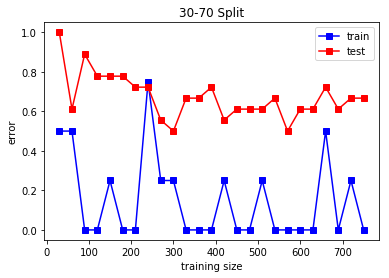

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(batch_sizes_orig, train_error_orig, 'xb-', marker="s", label='train')
ax1.plot(batch_sizes_orig, test_error_orig, 'xr-', marker="s", label='test')
plt.ylabel('error')
plt.xlabel('training size')
plt.title("30-70 Split")
plt.legend(loc='upper right');
plt.show()

Looking at the plot what you see is the training error varies quite a lot from zero to 40% to 60% and this is probably caused by the high bias caused by limited positive basket ball images. So when a batch  is 